In [1]:
# spark libraries
import pyspark
from pyspark.sql.functions import max

# data wrangling
import pandas as pd
import numpy as np

In [24]:
df = pd.read_csv('hard_drives_smart_5.csv').drop(columns='Unnamed: 0')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 10 columns):
serial_number         169072 non-null object
model                 169073 non-null object
capacity_bytes        169073 non-null int64
max(failure)          169073 non-null int64
max(smart_9_raw)      161975 non-null float64
max(smart_5_raw)      161851 non-null float64
max(smart_187_raw)    104189 non-null float64
max(smart_188_raw)    104179 non-null float64
max(smart_197_raw)    161841 non-null float64
max(smart_198_raw)    161841 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.9+ MB


In [26]:
df.isnull().sum()

serial_number             1
model                     0
capacity_bytes            0
max(failure)              0
max(smart_9_raw)       7098
max(smart_5_raw)       7222
max(smart_187_raw)    64884
max(smart_188_raw)    64894
max(smart_197_raw)     7232
max(smart_198_raw)     7232
dtype: int64

In [27]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [28]:
def prepare(df):
    
    # Convert capacity column from bytes to gigabytes
    df['capacity_bytes'] = round((df['capacity_bytes']/ 1_000_000_000),1)

    # Convert power hours to years
    df['max(smart_9_raw)'] = round((df['max(smart_9_raw)']/ 8760),1)

    # Create a new column for manufacturer
    df['manufacturer'] = df.model.apply(get_manufacturer)
    
    # Rename columns appropriately
    df = df.rename(columns={'capacity_bytes':'capacity_gigabytes',
                        'max(failure)':'failure',
                        'max(smart_9_raw)':'drive_age_in_years',
                        'max(smart_5_raw)':'reallocated_sectors_count',
                        'max(smart_187_raw)':'reported_uncorrectable_errors',
                        'max(smart_188_raw)':'command_timeout',
                        'max(smart_197_raw)':'current_pending_sector_count',
                        'max(smart_198_raw)':'uncorrectable_sector_count'})

    # Reorder columns 
    df = df[['serial_number','manufacturer','model','capacity_gigabytes',
          'failure','drive_age_in_years','reallocated_sectors_count',
         'reported_uncorrectable_errors','command_timeout',
          'current_pending_sector_count','uncorrectable_sector_count']]
    
    return df


def unique(df):
    '''
    Remove rows that duplicate serial numbers after aggregation.
    '''
    
    # remove rows with 0 copacity_gigabytes they were creating duplicate rows for some of the serial numbers
    df = df[df.capacity_gigabytes > 0]
    
    # remove rows by index that were creating duplicate serial numbers 
    df = df.drop([68273,50408,37150,154660,162948,50816,156370,31687,20823,75191,132189,4177,78104,103620,141505,95249,26969])
    
    return df

def get_manufacturer(model):
    if model.startswith('ST'):
        return 'Seagate'
    elif model.startswith('Sea'):
        return 'Seagate'
    elif model.startswith('HGST'):
        return 'Hitachi'
    elif model.startswith('Hit'):
        return 'Hitachi'
    elif model.startswith('TOS'):
        return 'Toshiba'
    elif model.startswith('DEL'):
        return 'Dell'
    elif model.startswith('WD'):
        return 'Western Digital'
    elif model.startswith('Sam'):
        return 'Samsung'
    elif model.startswith('SAM'):
        return 'Samsung'
    else:
        return 'Unknown'

def treat_nulls(df):
    # remove nulls from specific columns by imputing zeroes
    df.reported_uncorrectable_errors = df.reported_uncorrectable_errors.fillna(value=0)
    df.command_timeout = df.command_timeout.fillna(value=0)
    
    # treat remaining nulls by dropping specific rows
    df = df.dropna(axis=0)
    return df

In [29]:
df = prepare(df)

In [30]:
df = unique(df)

In [31]:
df.manufacturer.value_counts()

Seagate            105136
Hitachi             51417
Western Digital      2826
Toshiba              2573
Dell                   60
Samsung                11
Unknown                 2
Name: manufacturer, dtype: int64

In [33]:
df [df.manufacturer == 'Dell'].model.value_counts()

DELLBOSS VD    60
Name: model, dtype: int64

In [40]:
df [df.manufacturer == 'Dell']

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
3317,d2830942e1ca0010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN
5872,ad6def546aea0010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN
7477,3b8f38bf6bc90010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN
8306,5de287ae7c050010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN
16588,10ca0ecb78690010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN
16602,17eddeea3c620010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN
25038,56cc876a649c0010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN
28453,4d03b7d534ea0010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN
30158,cce2cfe98b7f0010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN
30172,507b941884d90010,Dell,DELLBOSS VD,480.0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df = treat_nulls(df)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_gigabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


In [43]:
df.isnull().sum()

serial_number                    0
manufacturer                     0
model                            0
capacity_gigabytes               0
failure                          0
drive_age_in_years               0
reallocated_sectors_count        0
reported_uncorrectable_errors    0
command_timeout                  0
current_pending_sector_count     0
uncorrectable_sector_count       0
dtype: int64

In [44]:
df.head()

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4000.8,0,5.0,0.0,0.0,0.0,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4000.8,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,4.8,0.0,0.0,0.0,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8001.6,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,5.5,0.0,0.0,0.0,0.0,0.0


In [45]:
df.manufacturer.value_counts()

Seagate            105012
Hitachi             51417
Western Digital      2826
Toshiba              2573
Unknown                 1
Samsung                 1
Name: manufacturer, dtype: int64

In [47]:
df [df.manufacturer == 'Unknown']

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
33381,0F112CC45,Unknown,00MD00,4000.8,0,1.7,0.0,0.0,0.0,0.0,0.0


In [56]:
df.shape

(161830, 11)

In [58]:
df [df.serial_number.duplicated(keep=False)].sort_values('serial_number')

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count


In [59]:
df [(df.capacity_gigabytes < 1) & (df.failure == 1)]

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count


In [61]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [67]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print()

serial_number
JK11A8B9J77GNF    1
ZA1817QB          1
ZCH0G23S          1
ZA15LMLN          1
ZA219N5Z          1
                 ..
ZA2177ML          1
Z304LA7A          1
2AGPU5HY          1
PL1331LAHDYETH    1
ZCH092FK          1
Name: serial_number, Length: 161830, dtype: int64

manufacturer
Seagate            105012
Hitachi             51417
Western Digital      2826
Toshiba              2573
Unknown                 1
Samsung                 1
Name: manufacturer, dtype: int64

model
ST12000NM0007           38271
ST4000DM000             36156
HGST HMS5C4040BLE640    16314
ST8000NM0055            14810
HGST HUH721212ALN604    10875
                        ...  
ST3500320AS                 1
WDC WD800JD                 1
ST1000LM024 HN              1
SAMSUNG HD154UI             1
HGST HMS5C4040BLE641        1
Name: model, Length: 97, dtype: int64

capacity_gigabytes
4000.8     64877
12000.1    50729
8001.6     26106
3000.6      6789
2000.4      4675
500.1       2529
6001.2      2411

In [68]:
df_fails = df [df.failure == 1]
df_lives = df [df.failure == 0]

In [69]:
df_fails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5911 entries, 68 to 168960
Data columns (total 11 columns):
serial_number                    5911 non-null object
manufacturer                     5911 non-null object
model                            5911 non-null object
capacity_gigabytes               5911 non-null float64
failure                          5911 non-null int64
drive_age_in_years               5911 non-null float64
reallocated_sectors_count        5911 non-null float64
reported_uncorrectable_errors    5911 non-null float64
command_timeout                  5911 non-null float64
current_pending_sector_count     5911 non-null float64
uncorrectable_sector_count       5911 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 554.2+ KB


In [70]:
df_fails.drive_age_in_years.value_counts(bins=10, sort=False)

(-0.011300000000000001, 1.03]    1450
(1.03, 2.06]                     1840
(2.06, 3.09]                     1164
(3.09, 4.12]                     1095
(4.12, 5.15]                      280
(5.15, 6.18]                       65
(6.18, 7.21]                       11
(7.21, 8.24]                        1
(8.24, 9.27]                        1
(9.27, 10.3]                        4
Name: drive_age_in_years, dtype: int64

In [71]:
df_lives.drive_age_in_years.value_counts(bins=10, sort=False)

(-0.0092, 0.82]    24004
(0.82, 1.64]       15924
(1.64, 2.46]       30528
(2.46, 3.28]       20580
(3.28, 4.1]        29677
(4.1, 4.92]        24448
(4.92, 5.74]        9050
(5.74, 6.56]        1506
(6.56, 7.38]         161
(7.38, 8.2]           41
Name: drive_age_in_years, dtype: int64

In [72]:
df_fails.drive_age_in_years.agg(['mean','median'])

mean      2.064642
median    1.800000
Name: drive_age_in_years, dtype: float64

In [73]:
df_lives.drive_age_in_years.agg(['mean','median'])

mean      2.747618
median    2.700000
Name: drive_age_in_years, dtype: float64

In [76]:
df_fails.drive_age_in_years.describe()

count    5911.000000
mean        2.064642
std         1.311870
min         0.000000
25%         1.100000
50%         1.800000
75%         3.000000
max        10.300000
Name: drive_age_in_years, dtype: float64

In [77]:
df_lives.drive_age_in_years.describe()

count    155919.000000
mean          2.747618
std           1.526695
min           0.000000
25%           1.600000
50%           2.700000
75%           4.000000
max           8.200000
Name: drive_age_in_years, dtype: float64

In [78]:
df_fails.manufacturer.value_counts()

Seagate            5070
Hitachi             502
Western Digital     189
Toshiba             150
Name: manufacturer, dtype: int64

In [79]:
df_lives.manufacturer.value_counts()

Seagate            99942
Hitachi            50915
Western Digital     2637
Toshiba             2423
Unknown                1
Samsung                1
Name: manufacturer, dtype: int64

In [80]:
df_fails.reallocated_sectors_count.mean()

1440.3172052106243

In [81]:
df_lives.reallocated_sectors_count.mean()

17.90471975833606

In [82]:
df.serial_number.nunique()

161830

In [83]:
df.model.value_counts() [df.model.value_counts() > 100]

ST12000NM0007              38271
ST4000DM000                36156
HGST HMS5C4040BLE640       16314
ST8000NM0055               14810
HGST HUH721212ALN604       10875
ST8000DM002                10160
HGST HMS5C4040ALE640        8637
Hitachi HDS5C3030ALA630     4563
Hitachi HDS722020ALA330     4503
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1912
HGST HUH721212ALE600        1564
TOSHIBA MG07ACA14TA         1302
ST10000NM0086               1235
WDC WD30EFRX                1167
HGST HUH728080ALE600        1082
Hitachi HDS723030ALA640     1000
ST500LM012 HN                804
TOSHIBA MQ01ABF050           589
WDC WD60EFRX                 471
ST4000DM001                  425
TOSHIBA MQ01ABF050M          410
WDC WD5000LPVX               343
WDC WD10EADS                 295
ST31500541AS                 264
ST500LM030                   261
ST4000DX000                  212
WDC WD20EFRX                 158
TOSHIBA MD04ABA400V          147
HGST HDS5C4040ALE630         116
WDC WD1600

In [84]:
df.model.nunique()

97

In [85]:
len(df.model.value_counts() [df.model.value_counts() > 100])

31

In [86]:
df.model.value_counts() [df.model.value_counts() > 100].sum()

160786

In [87]:
df.model.count()

161830

In [88]:
df.model.value_counts() [df.model.value_counts() > 100].sum() / df.model.count()

0.9935487857628376

In [92]:
df_fails.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_gigabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count'],
      dtype='object')

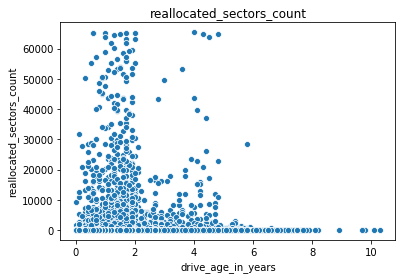

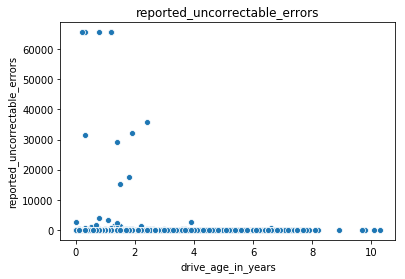

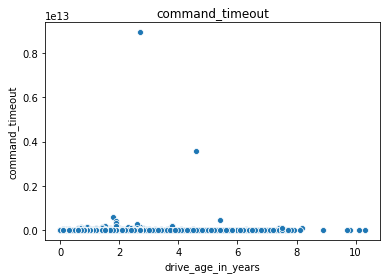

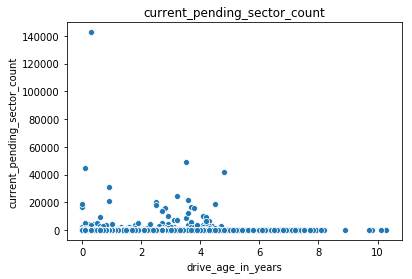

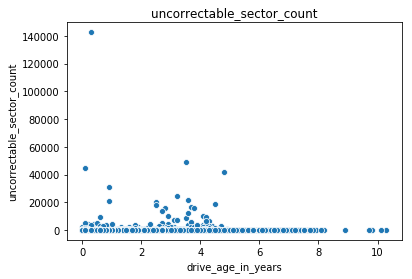

In [98]:
for col in df_fails.columns[6:]:
    sns.scatterplot(data=df, y=df[col], x=df.drive_age_in_years)
    plt.title(col)
    plt.show()

In [94]:
df_fails [df_fails.reported_uncorrectable_errors > 0].count()

serial_number                    2079
manufacturer                     2079
model                            2079
capacity_gigabytes               2079
failure                          2079
drive_age_in_years               2079
reallocated_sectors_count        2079
reported_uncorrectable_errors    2079
command_timeout                  2079
current_pending_sector_count     2079
uncorrectable_sector_count       2079
dtype: int64

In [99]:
df [df.reported_uncorrectable_errors > 0]

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
47,Z304KCF4,Seagate,ST4000DM000,4000.8,0,3.9,0.0,3.0,0.0,8.0,8.0
67,ZA127XZQ,Seagate,ST8000DM002,8001.6,0,3.3,0.0,11.0,0.0,0.0,0.0
68,Z304KBQR,Seagate,ST4000DM000,4000.8,1,3.6,8.0,11.0,0.0,72.0,72.0
116,Z302FETY,Seagate,ST4000DM000,4000.8,1,3.1,0.0,4.0,0.0,40.0,40.0
133,ZA13R24Q,Seagate,ST8000DM002,8001.6,1,2.4,1984.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
168869,ZCH0CLFQ,Seagate,ST12000NM0007,12000.1,1,0.6,8.0,2.0,0.0,0.0,0.0
168884,ZJV03NK5,Seagate,ST12000NM0007,12000.1,1,1.2,80.0,1.0,0.0,0.0,0.0
168940,ZJV1K5HB,Seagate,ST12000NM0007,12000.1,1,0.8,18288.0,65.0,131074.0,0.0,0.0
168960,ZJV03T4K,Seagate,ST12000NM0007,12000.1,1,0.8,432.0,1.0,0.0,0.0,0.0


In [100]:
df [df.reported_uncorrectable_errors == 0]

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4000.8,0,5.0,0.0,0.0,0.0,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4000.8,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,4.8,0.0,0.0,0.0,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8001.6,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,5.5,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
169051,ZCH076Z5,Seagate,ST12000NM0007,12000.1,0,0.7,0.0,0.0,0.0,0.0,0.0
169052,ZJV5HDV2,Seagate,ST12000NM0007,12000.1,0,0.0,0.0,0.0,0.0,0.0,0.0
169053,AAG779PH,Hitachi,HGST HUH721212ALN604,12000.1,0,0.6,0.0,0.0,0.0,0.0,0.0
169054,AAG6XZGH,Hitachi,HGST HUH721212ALN604,12000.1,0,0.6,0.0,0.0,0.0,0.0,0.0


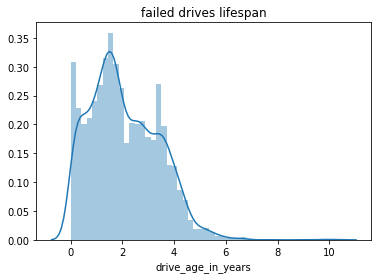

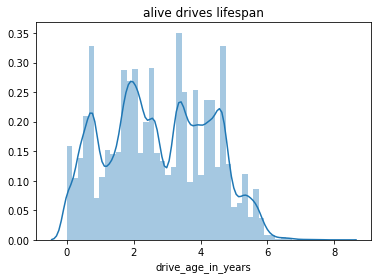

In [102]:
# plt.figure(figsize=(12,8))
sns.distplot(df_fails.drive_age_in_years)
plt.title('failed drives lifespan')
plt.show()

sns.distplot(df_lives.drive_age_in_years)
plt.title('alive drives lifespan')
plt.show()

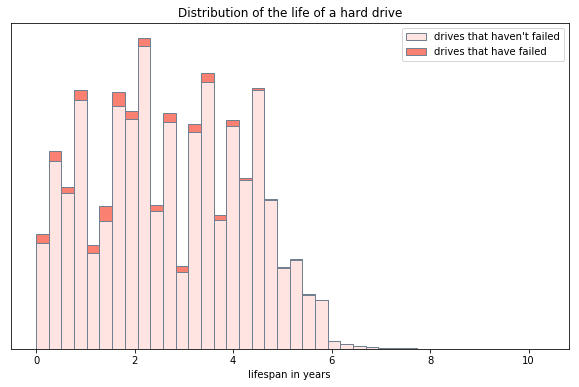

In [169]:
plt.figure(figsize=(10,6))
plt.hist([df_lives.drive_age_in_years, df_fails.drive_age_in_years], stacked=True, bins=40,
         edgecolor='slategrey', color=['mistyrose','salmon'])
plt.legend(["drives that haven't failed","drives that have failed"])
plt.title("Distribution of the life of a hard drive")
plt.xlabel("lifespan in years")
plt.yticks([])
plt.show()

In [200]:
df['smart_9_nonzero'] = np.where(df.reallocated_sectors_count > 0, '1','0')
df['smart_187_nonzero'] = np.where(df.reported_uncorrectable_errors > 0, '1', '0')
df['smart_188_nonzero'] = np.where(df.command_timeout > 0, '1', '0')
df['smart_197_nonzero'] = np.where(df.current_pending_sector_count > 0, '1', '0')
df['smart_198_nonzero'] = np.where(df.uncorrectable_sector_count > 0, '1', '0')

In [201]:
df

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,smart_9_nonzero,smart_187_nonzero,smart_188_nonzero,smart_197_nonzero,smart_198_nonzero
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4000.8,0,5.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,Z305KB36,Seagate,ST4000DM000,4000.8,0,3.5,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,4.8,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
3,ZA11NHSN,Seagate,ST8000DM002,8001.6,0,3.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3000.6,0,5.5,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169052,ZJV5HDV2,Seagate,ST12000NM0007,12000.1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
169053,AAG779PH,Hitachi,HGST HUH721212ALN604,12000.1,0,0.6,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
169054,AAG6XZGH,Hitachi,HGST HUH721212ALN604,12000.1,0,0.6,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
169055,Z302ZCWX,Seagate,ST4000DM000,4000.8,0,0.1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [199]:
# df.drop(columns = ['smart_9_nonzero','smart_187_nonzero', 'smart_188_nonzero','smart_197_nonzero', 'smart_198_nonzero'], inplace=True)

In [218]:
for col in df.columns[11:]:
    df[col] = df[col].astype(int)

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 16 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_gigabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
smart_9_nonzero                  161830 non-null int64
smart_187_nonzero                161830 non-null int64
smart_188_nonzero                161830 non-null int64
smart_197_nonzero                161830 non-null int64
smart_198_nonzero                161830 non-nul

In [275]:
df.groupby('failure').sum().iloc[:,2:7]

,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
failure,,,,,
0,2791686.0,178262.0,2.149257e+13,42649.0,38515.0
1,8513715.0,446475.0,1.252003e+13,971429.0,918493.0


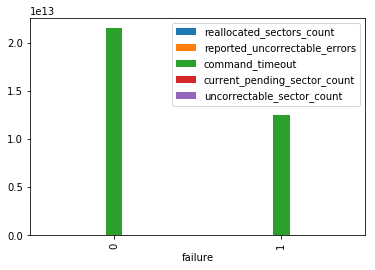

In [277]:
df.groupby('failure').sum().iloc[:,2:7].plot.bar()

In [268]:
df.groupby('failure').sum().iloc[:,7:]

,smart_9_nonzero,smart_187_nonzero,smart_188_nonzero,smart_197_nonzero,smart_198_nonzero
failure,,,,,
0,3693,1679,3813,1742,1440
1,1909,2079,559,2489,2190


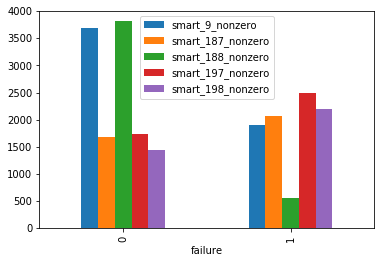

In [270]:
df.groupby('failure').sum().iloc[:,7:].plot.bar()

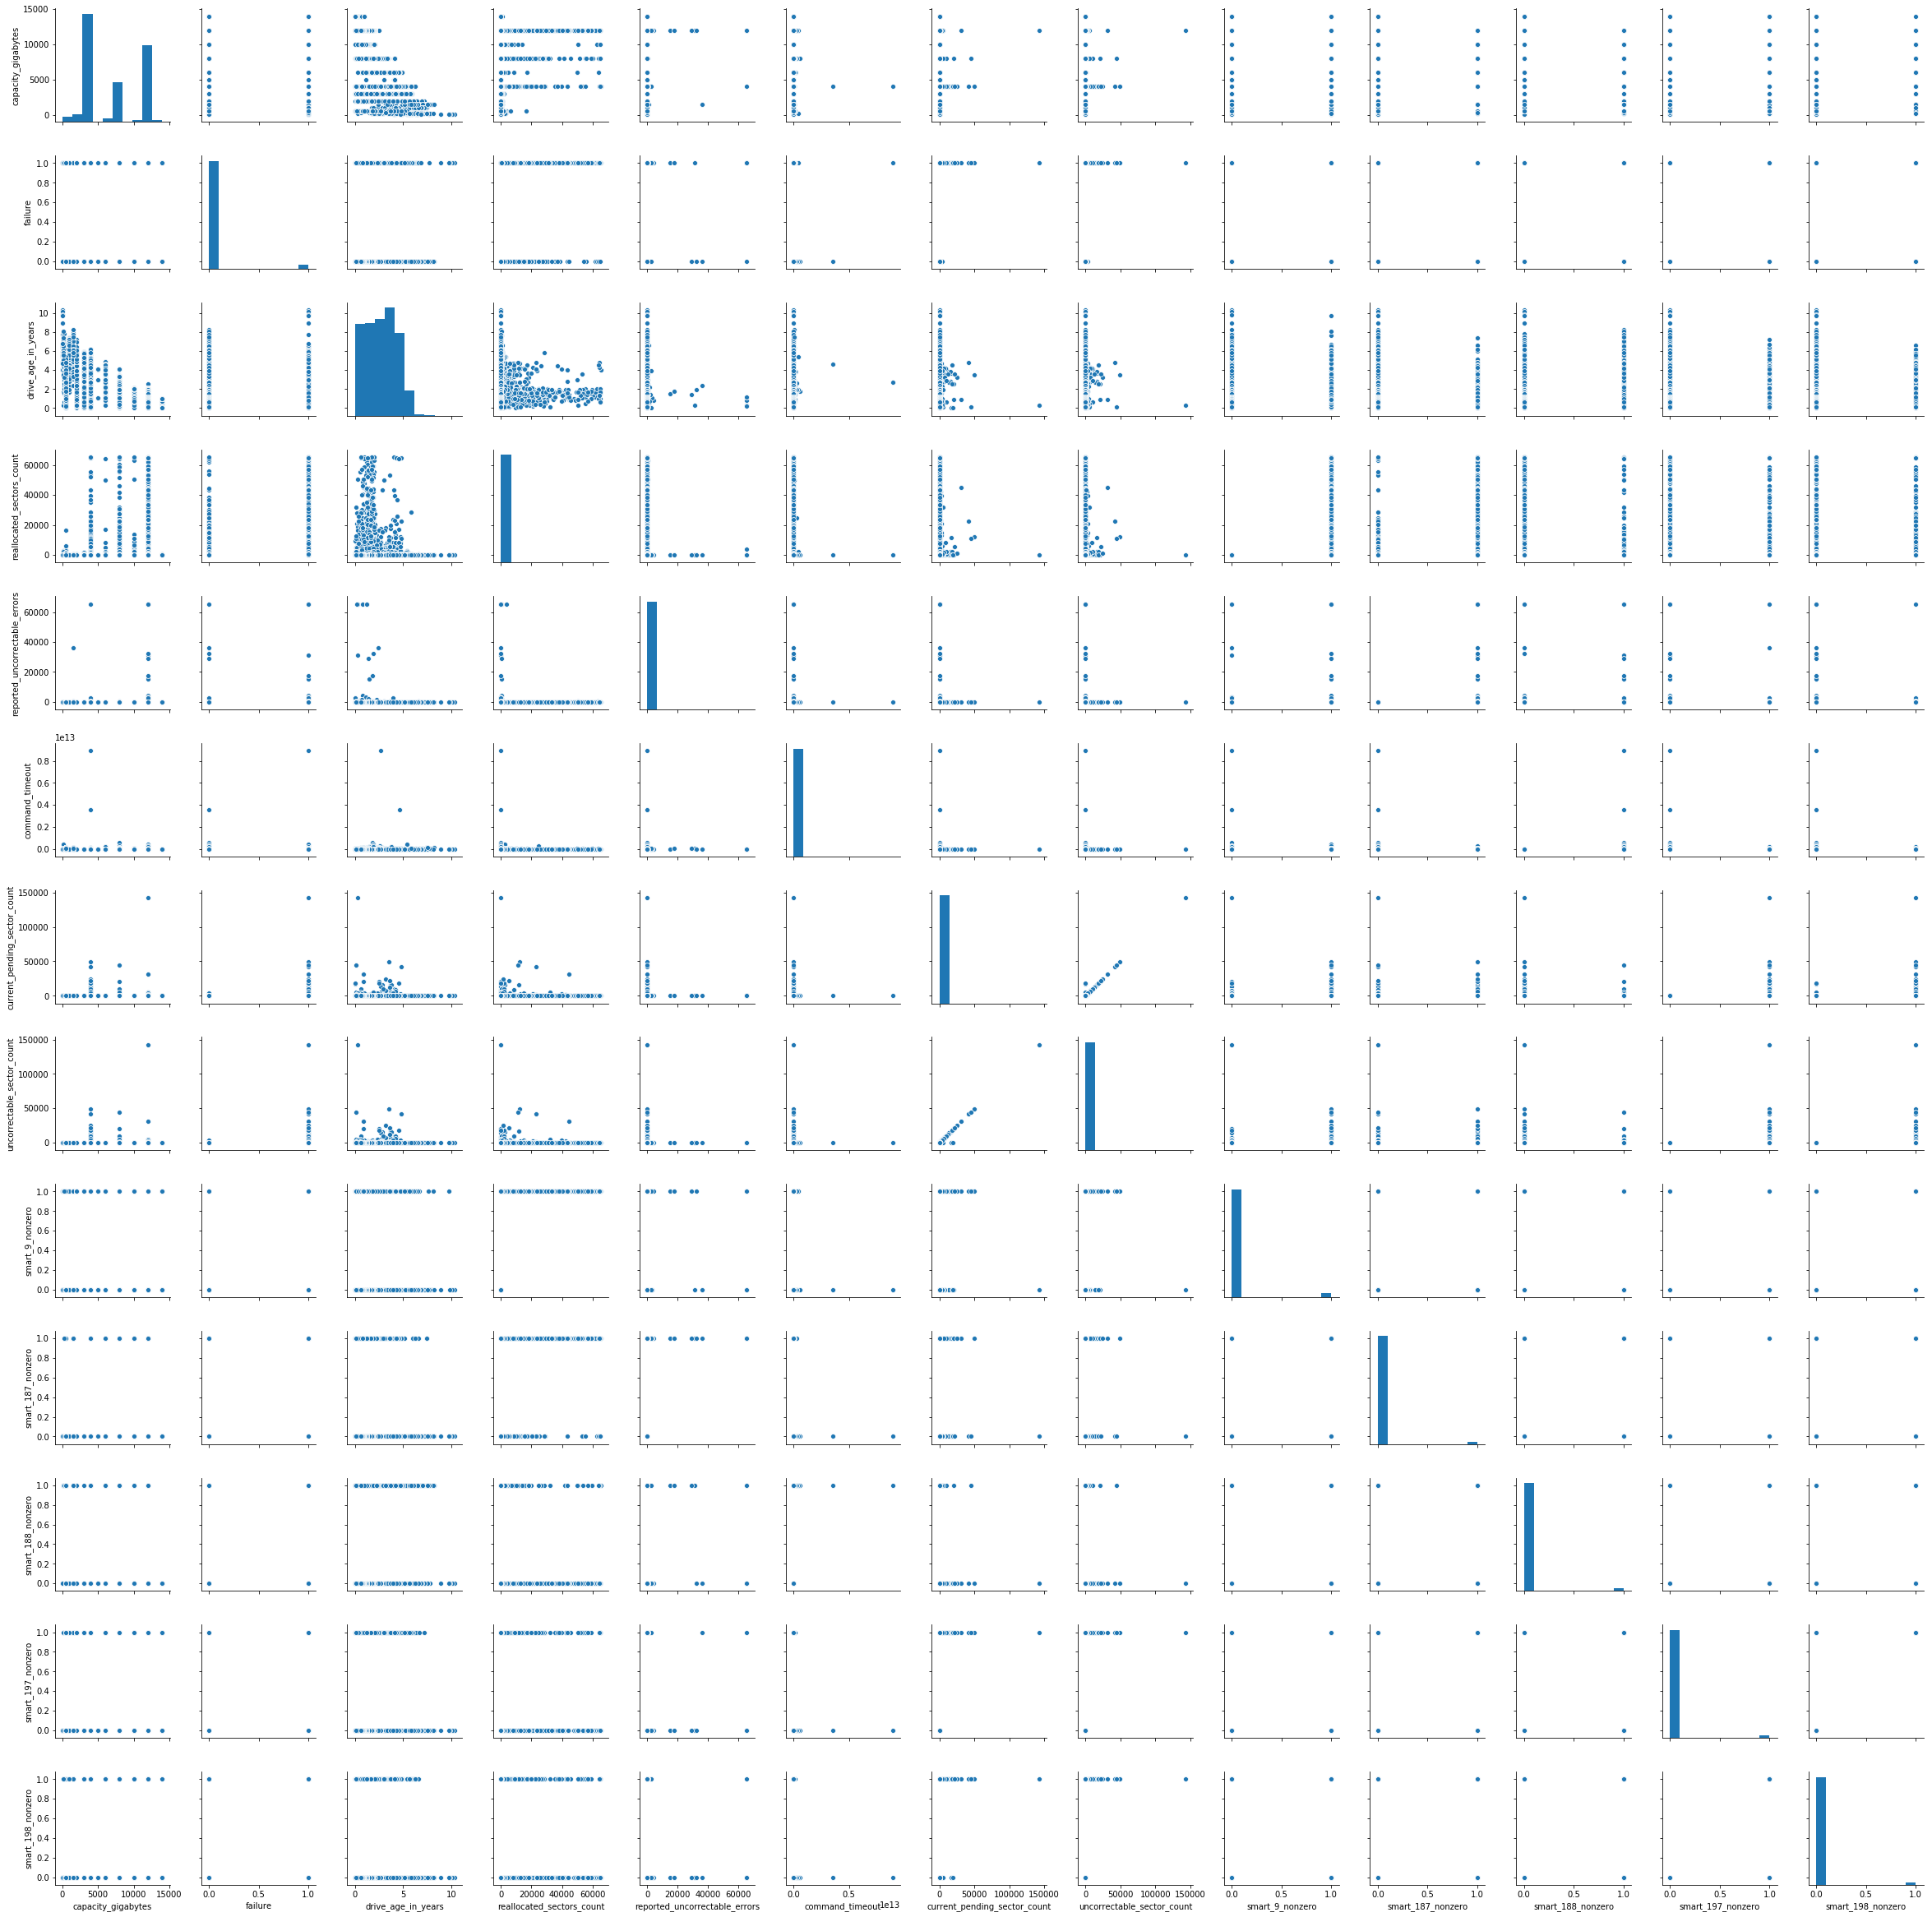

In [264]:
sns.pairplot(df)